# Ideal mean age

## The model

We will simulate the ideal mean age of water.
That is, the average amount of time since a water parcel had last contact with the surface.

### Tracer equation

The ideal mean age is transported with water, is equal to $0$ at the surface, and increases by one second every second everywhere.
In other words, the 3D field of the age, $a$, is governed by the tracer equation

$$\frac{\partial a}{\partial t} = - \nabla \cdot \left[ \boldsymbol{u} - \mathbf{K} \cdot \nabla \right] a + 1,$$

where $\nabla \cdot \left[ \boldsymbol{u} - \mathbf{K} \cdot \nabla \right]$ is a differential operator that represents the transport by the ocean circulation.
($\boldsymbol{u}$ is the 3D vector field for the advection and $\mathbf{K}$ is the diffusivity matrix.)
In the equation above, we also assume that there is the boundary condition that $a=0$ at the surface.

### Discretized tracer equation

In AIBECS, the linear differential operator defined by $\nabla \cdot \left[ \boldsymbol{u} - \mathbf{K} \cdot \nabla \right]$ is approximated by a constant matrix $\mathbf{T}$ when discretizing the continuous 3D ocean onto the model grid.
This matrix can be small (e.g., for models with a few boxes), or large, like for the OCIM (more on the OCIM later).
Similarly, the continuous 3D field of the age, $a$, is discretized into a column-vector, $\boldsymbol{a}$.
(We represent scalars in italic, vectors in bold italic, and matrices in upstraight bold.)

In the discrete case, we replace the boundary condition (that $a = 0$ at the surface) by imposing $\boldsymbol{a} = 0$ in the surface layer of the model grid.
In practice, this is done by restoring $\boldsymbol{a}$ to $0$ with a very short timescale.
The tracer equation thgus takes the form of

$$\frac{\partial\boldsymbol{a}}{\partial t} = -\mathbf{T} \, \boldsymbol{a} + 1 - \boldsymbol{a} / \tau,$$

where $\tau$ will be chosen to be very small, ensuring that $\boldsymbol{a}$ is very close to $0$ at the surface.
The first term represents the transport by the ocean circulation, the second term the source of 1 second per second everywhere, and the last term the fast relaxation.

### Steady-state

The steady-state is the equilibrium that would be reached if we wait long enough for $a$ to not change anymore.
Mathematically, the steady-state is also the state for which

$$\frac{\partial a}{\partial t} = 0.$$

Computationally, in the discrete case, this means that we just need to solve

$$0 = -\mathbf{T} \, \boldsymbol{a} + 1 - \boldsymbol{a} / \tau$$

to find $\boldsymbol{a}$.
More specifically, we need to solve

$$(\mathbf{T} + \mathbf{I} / \tau) \, \boldsymbol{a} = 1.$$

Now that we have the equations laid down, let us chose the circulation transport matrix, $\mathbf{T}$.

## Using AIBECS

> **Note**
> If this is the first time you are trying AIBECS, make sure you go through the prerequisites!

AIBECS can interpret tracer equations as long as you arrange them under the generic form:

$$\frac{\partial \boldsymbol{x}}{\partial t} = \boldsymbol{F}(\boldsymbol{x}, \boldsymbol{p}),$$

where $\boldsymbol{F}(\boldsymbol{x}, \boldsymbol{p})$ is the rate of change of the state and $\boldsymbol{p}$ is the vector of model parameters.
We only track the age here, so that the entire state of the system is determined by the age itself.
In other words, here, $\boldsymbol{x} = \boldsymbol{a}$.

We will use AIBECS to find the steady-state of the system.
For AIBECS, this translates into finding the solution of $\boldsymbol{F}(\boldsymbol{x}, \boldsymbol{p}) = 0$.

We start by telling Julia that we want to use the AIBECS package via

In [1]:
using AIBECS

> **Note**
> If it's the first time you are running this line, the package will need precompiling.
> This may take a minute or two.
> (Just be patient... Or read on while you wait!)

> **Note**
> You should see a `Warning` for the `Flatten` package — just disregard it...
> If you get an error though, please send me a copy of the output/error message, and I will try to troubleshoot it.

### The circulation

We will use the circulation output from the Ocean Circulation Inverse Model (OCIM) version 1.1.
Basically, the OCIM provides researchers and oceanographers with a big sparse matrix that represents the global ocean circulation (advection and diffusion), which allows them to efficiently simulate the transport of passive tracers, like the age.
(For more details, see Tim DeVries's [website](https://tdevries.eri.ucsb.edu/models-and-data-products/) and references therein.)
With AIBECS, the OCIM circulation can be loaded really easily, by simply typing

In [2]:
const wet3d, grd, T_OCIM = AIBECS.OCIM1.load()
typeof(T_OCIM), size(T_OCIM)

Loading OCIM1 with JLD2┌ Warning: Checksum not provided, add to the Datadep Registration the following hash line
│   hash = "345dc8a49445d02091cfe06818bc4ee617bf33dee7f8d92f298c26ed74d84684"
└ @ DataDeps /home/travis/.julia/packages/DataDeps/LiEdA/src/verification.jl:44
 ✅


(SparseMatrixCSC{Float64,Int64}, (200160, 200160))

Here, I have used the `const` prefix to tell Julia these are constants (it helps Julia's compiler)

> **Note**
> Julia may ask you to download the OCIM matrix for you, in which case you should say yes (i.e., type `y`).
> Once downloaded, AIBECS will remember where it downloaded the file and it will only load it from your laptop.

Additionally to downloading the OCIM file, the `load()` command loads 3 variables in the Julia workspace:
- `wet3d` — a 3D array of the model grid, filled with `1`'s at "wet" grid boxes and `0`'s and "land" grid boxes.
- `grd` — a dictionary containing information about the 3D grid of the OCIM circulation, like the latitude, longitude, and depth of each grid boxes. `grd` is a dictionary (i.e., a `Dict` in Julia, which is equivalent to a `struct` in MATLAB or a `dict` in python).
- `T_OCIM` — the transport matrix representing advection and diffusion.

The second line in command above tells you the type and the size of `T_OCIM`.
It is a sparse matrix (CSC just means that it is stored in Compressed Sparse Column format) and is quite big!
> **Note**
> A sparse matrix is just a matrix with very few non-zero entries.
> Computationally, sparse matrices are stored differently than full matrices to save memory (no need to save all those zeros), and are much faster to use too!

Anyway, this looks good, so let's move on with setting up the model!

We have already loaded the transport matrix, `T_OCIM`, for the ocean circulation, but we must tell AIBECS that it applies to the age.
To do that, we define a function of the parameters (although there are no parameters involved in this case, this is just the way AIBECS works for the moment).

In [3]:
T_age(p) = T_OCIM

T_age (generic function with 1 method)

(Functions in Julia can be created in one line, just as above.)
That's it for the circulation.
Now, let's define the local sources and sinks.

### The local sources and sinks

We will denote the age, $\boldsymbol{a}$, by the variable `age` in Julia.
(It's good practice to use explicit names!)
We need to translate the local sources and sinks in our discretized state function $\boldsymbol{F}(\boldsymbol{x}, \boldsymbol{p})$ into Julia code.

#### The source

Remember the age increases by $1$ second every second and everywhere.
So its source function is equal to, well, `1`! (seconds per seconds means it is unitless).
Let's create the local source function:

In [4]:
source_age(age, p) = 1

source_age (generic function with 1 method)

#### The sink

Recall that the age must also be $0$ at the surface.
And that we implement this boundary condition by restoring the age very fast to $0$ in the surface layer.
This will act as the sink for the age.
But first, we need to figure out where "the surface layer" is.
To do that, AIBECS can generate a number of useful constants for you.
(You can see the list of functions by typing `varinfo(AIBECS)` at the REPL.)
Here we will use the vector of grid box depths, `z`, which AIBECS can generate for us via

In [5]:
const z = vector_of_depths(wet3d, grd)

200160-element Array{Float64,1}:
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
    ⋮              
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175

So what is the top layer?
Let's investigate what's the minimum depth:

In [6]:
minimum(z)

18.0675569520817

The surface layer in the OCIM grid has its center at about $18\,$m depth.
We can create a mask of the surface layer via `z .< 20`.
(This will return a vector of `0`s and `1`s, depending on whether the depth, `z`, is less than `20`.)

> **Note**
> In Julia (like in MATLAB), placing a dot, `.`, in front of operators is a convenient way to do element-wise operations.

Then, we implement the local sink by restoring the age to `0` with a timescale `τ`, via

In [7]:
function sink_age(age, p)
    τ = p.τ
    return age .* (z .< 20) / τ
end

sink_age (generic function with 1 method)

> **Note**
> Julia allows you to use unicode for your functions and variables, like for `τ`.

Here, we have defined a Julia function using the `function` keyword because the sink is a bit more complicated, so that we needed two lines to define it.
The first line unpacks the model parameters, which is just the restoring timescale, `τ`, in this case.
We will chose the value for `τ` later.

#### Net sources and sinks

The sources minus the sinks are simply defined by

In [8]:
sms_age(age, p) = source_age(age, p) .- sink_age(age, p)

sms_age (generic function with 1 method)

#### Model parameters

We must define the parameters... And AIBECS comes with an API for that!

In [9]:
t = empty_parameter_table()    # initialize table of parameters
add_parameter!(t, :τ, 1u"s")   # add the parameter we want (τ = 1s)
initialize_Parameters_type(t, "IdealAgeParameters")  # Generate the parameter type
t

,symbol,value,unit,printunit,mean_obs,variance_obs,optimizable,description
,Symbol,Float64,Unitful…,Unitful…,Float64,Float64,Bool,String
1,τ,1.0,s,s,NaN,NaN,0,


Note, in particular, that we gave our parameter `τ` a unit.
Yes, Julia comes with some nice functionality to deal with units directly!
The lines above created a table that contains all the info for generating the parameters vector, $\boldsymbol{p}$.
To generate the parameters in AIBECS we do:

In [10]:
p₀ = IdealAgeParameters()

     τ = 1.00e+00 [s] (fixed)


where we have used the constructor `IdealAgeParameters`, whose name we defined in the previous cell.
Here we did not really need to create `p₀` as a parameters vector, since it has only one element, `τ`, in it.
However, we are here to learn, and this structure and functionality comes in very handy when one deals with many parameters.
(And as you can imagine, having all the parameters in a nice table ready for being used in a publication comes quite handy!)

#### State function and Jacobian

Similarly to `p₀`, let's create a state `x₀` to start with.
The vector `x₀` will be our initial guess for the state.
Let's assume that the age is `1` (seconds) everywhere (as an initial guess):

In [11]:
const nb = number_of_wet_boxes(wet3d)  # number of wet boxes
x₀ = ones(nb)

200160-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮  
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

The first line above defines the number of wet grid boxes, `nb`.
Here, this is also the length of the state vector `x`, because there is only one tracer, `age`.
In the second line, the `ones` function creates a vector of `1`s of the size you give it (the number of wet grid boxes, `nb`, here, which we defined as a constant earlier).

Finally, the last step for the set up is to define $\boldsymbol{F}$.
Using AIBECS, this is done via

In [12]:
T_matrices = (T_age,)           # bundles all the transport matrices in a tuple
sources_minus_sinks = (sms_age,) # bundles all the source-sink functions in a tuple
F, ∇ₓF = state_function_and_Jacobian(T_matrices, sources_minus_sinks, nb) # generates the state function (and its Jacobian!)
F(x₀,p₀)

200160-element Array{Float64,1}:
  3.5883947382171576e-17
 -2.809435835428409e-16 
  1.5274953599623277e-16
 -2.1312760453915457e-16
 -5.743646373781175e-17 
  1.0546612697927452e-16
 -6.087469454780884e-18 
  1.3194314441133124e-16
  4.684425965693446e-17 
 -9.524083788424921e-17 
  ⋮                     
  1.0                   
  1.0                   
  1.0                   
  1.0                   
  1.0                   
  1.0                   
  1.0                   
  1.0                   
  1.0                   

That's it!
We have just created a model of the mean age.


Lines 2 and 3 are just telling AIBECS
- what transport matrices it should use for the transport of these tracers, and
- and what local sources and sinks should be appplied to these tracers

> **Note**
> The `(x,)` syntax returns a tuple of one element — the comma is necessary because without it, `(x)` would be just like `x` with brackets around it.
> This interface of AIBECS was developed for case with multiple tracers in mind, and might look a bit odd for a single tracer.
> But in the future, this might be cleaned up to be easier to work with single tracers.

The fourth line creates two functions:
- `F` — the numerical version of the **state function**, $\boldsymbol{F}$, of our model of the mean age, and
- `∇ₓF` — the **Jacobian matrix** of the state function, i.e., $\nabla_{\boldsymbol{x}}\boldsymbol{F}$.
Yes, AIBECS just automatically created an exact derivative of your input, using autodifferentiation via dual numbers.
(I'd be very excited to detail how this is implemented here, but it is an entirely different discussion.)

The last line just checks that our generated `F` works with our initial guess `x₀` and parameter vector `p₀`.

#### Solving for the steady-state

The Jacobian, `∇ₓF` is essential to solving the steady-state equation $\boldsymbol{F}(\boldsymbol{x}, \boldsymbol{p}) = 0$ fast.
Specifically, solving $\boldsymbol{F}(\boldsymbol{x}, \boldsymbol{p}) = 0$ is done via Newton's method.
By starting from an initial guess, that you will have to provide, it will iterate over this recursion relation

$$\boldsymbol{x}_{k+1} = \boldsymbol{x}_{k} - \nabla_{\boldsymbol{x}}\boldsymbol{F}(\boldsymbol{x}_{k}, \boldsymbol{p})^{-1} \boldsymbol{F}(\boldsymbol{x}_{k}, \boldsymbol{p})$$

until $\boldsymbol{F}(\boldsymbol{x}_{k}, \boldsymbol{p})$ is sufficiently small.
Now I should note that here, our age model is linear in $x$ (or `age` in our code), so that the solution will be found in a single iteration, or a sinle "matrix inversion", as could be seen from our steady-state equation for $\boldsymbol{a}$.

> **Note**
> AIBECS comes with a built-in algorithm and an API to solve for the steady-state, so you don't have to worry about all these details!

##### Define the Steady-state problem in AIBECS

First, we create an instance of the steady-state problem, via

In [13]:
prob = SteadyStateProblem(F, ∇ₓF, x₀, p₀)

SteadyStateProblem with uType Array{Float64,1}
u0: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

where we have simply provided the state function, $\boldsymbol{F}$, the Jacobian, $\nabla_{\boldsymbol{x}}\boldsymbol{F}$, the initial guess and the parameters.
The `SteadyStateProblem` function is a standard "DiffEqBase" constructor that I have overloaded in my package so that you can easily generate the model here.

##### Solve for the steady-state with AIBECS

Finally, we can find the solution in litterally one line, via the `solve` function:

In [14]:
age = solve(prob, CTKAlg())

u: 200160-element Array{Float64,1}:
  399.4681454710088      
 2241.017273529228       
  569.8178412438044      
  102.84590560936951     
  557.0875596657708      
  340.0779830364383      
  448.4099283263092      
  510.2501567581283      
  295.6723665367146      
  340.0552152030535      
    ⋮                    
    1.055730169393073e10 
    1.043684898888338e10 
    1.0739651723277563e10
    1.0633121294493946e10
    1.0486088680482178e10
    1.0248016153142242e10
    1.0631798936593044e10
    1.0533857006807951e10
    1.0420308209358837e10

Here, I have provided the `solve` function with two things:
- the problem, `prob`, which we just defined, and
- the quasi-Newton algorithm that I wrote in Julia, denoted by `CTKAlg()` after C.T. Kelley, who originally wrote it in MATLAB.

The last line should take about 10 seconds to 1 minute, depending on your laptop.
That's it!
We solved for the steady state!
Everyone here deserves a nice tap on the shoulder — Good job!
Now let's see what this age looks like on a map

## Figures

We will plot a horizontal slice of the age at about 1000m depth using Cartopy.

First, we must rearrange `age` into the 3D model grid.
For that we will need the vector of the indices of wet points in the 3D grid, which we will denote by `iwet`, and which AIBECS generates via

In [15]:
const iwet = indices_of_wet_boxes(wet3d)

200160-element Array{Int64,1}:
     10
     11
     12
     13
     14
     15
     16
     17
     18
     19
      ⋮
 390450
 390451
 390539
 390540
 390541
 390542
 390630
 390631
 390632

We then rearrange the column vector `age` into a 3D array via

In [16]:
age_3D = NaN * wet3d # creates a 3D array of NaNs of the same size as `wet3d`
age_3D[iwet] = age   # Fills the wet grid boxes with the age values
size(age_3D)         # Just to check the size of age_3D

(91, 180, 24)

The last line just shows you the size of `age_3D`, which is a 3D-array as expected.

Now let us find the index of the depth that is closest to $1000\,$m.
To do that we must use the depth information contained in `grd`.
Let us first create a small vector of the depths of the grid:

In [17]:
depth = vec(grd["zt"])

24-element Array{Float64,1}:
   18.0675569520817 
   54.76728201099765
   93.72545168892381
  137.2005106048704 
  187.45090337784762
  246.7350746268657 
  317.3114689709348 
  401.4385310290652 
  501.3747054202671 
  619.3784367635507 
    ⋮               
 1833.2924194815398 
 2141.005498821681  
 2484.853692065986  
 2867.0954438334643 
 3289.9891987431265 
 3755.793401413983  
 4266.766496465043  
 4825.166928515318  
 5433.2531421838175 

We could count the index of the entry we want, but here we will use the `findfirst` function to find the first depth index that is greater than 1000m.
(Feel free to change the value of `iz` if you want to see a slice at another depth.)

In [18]:
iz = findfirst(depth .> 1000)
iz, depth[iz]

(13, 1104.3794186959938)

We get `iz = 13`, which is a layer that lies at 1104m, close to 1000m like we wanted.

Finally, we need the latitude and longitudes of the grid, contained in `grd`.
As for `depth`, we can use the OCIM's `grd` output:

In [19]:
lat, lon = vec(grd["yt"]), vec(grd["xt"])

([-89.01098901098901, -87.03296703296704, -85.05494505494505, -83.07692307692308, -81.0989010989011, -79.12087912087912, -77.14285714285714, -75.16483516483515, -73.18681318681318, -71.20879120879121  …  71.2087912087912, 73.18681318681318, 75.16483516483517, 77.14285714285712, 79.12087912087914, 81.0989010989011, 83.07692307692308, 85.05494505494504, 87.03296703296702, 89.01098901098901], [1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 19.0  …  341.0, 343.0, 345.0, 347.0, 349.0, 351.0, 353.0, 355.0, 357.0, 359.0])

So these are the latitudes and longitudes of the map we are about to plot.

A last thing we can do is convert the age from seconds, `u"s"`, to years, `u"yr"`, because the age is large.
This can be done via the Unitful package (loaded automatically by AIBECS).

In [20]:
age_3d_1000m_yr = age_3D[:,:,iz] * ustrip(1.0u"s" |> u"yr")

91×180 Array{Float64,2}:
 NaN       NaN       NaN       NaN       …  NaN       NaN       NaN     
 NaN       NaN       NaN       NaN          NaN       NaN       NaN     
 NaN       NaN       NaN       NaN          NaN       NaN       NaN     
 NaN       NaN       NaN       NaN          NaN       NaN       NaN     
 NaN       NaN       NaN       NaN          NaN       NaN       NaN     
 NaN       NaN       NaN       NaN       …  NaN       NaN       NaN     
 NaN       NaN       NaN       NaN          NaN       NaN       NaN     
 NaN       NaN       NaN       NaN          NaN       NaN       NaN     
 NaN       NaN       NaN       NaN          NaN       NaN       NaN     
 308.763   NaN       NaN       NaN          NaN       NaN       308.868 
   ⋮                                     ⋱                              
  61.8729   63.3087   65.6391   67.8197      63.5091   61.9053   61.5998
  52.8981   58.4094   63.5326   66.8945      56.0373   52.8544   50.7336
  59.3258   65.1104   70.4

Finally! Let's have a look at this ideal mean age!
To make figures, here, we use Cartopy.
(You should have installed Cartopy if you went through the prerequisites correctly).
To use it we simply type

In [21]:
ENV["MPLBACKEND"]="qt5agg"
using PyPlot, PyCall

┌ Warning: No working GUI backend found for matplotlib
└ @ PyPlot /home/travis/.julia/packages/PyPlot/cdCMF/src/init.jl:155


> **Note**
> The first line is needed for Mac users.
> It's a bug that should eventually be resolved, but for now this seems to make it work.

We import cartopy, define a new plot, add some coastlines because they are pretty, and add our slice of age at 1000m depth to it via

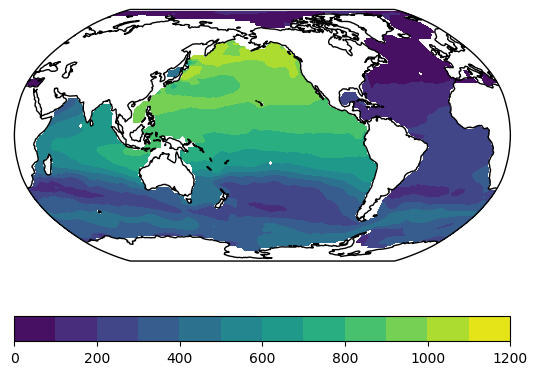

In [22]:
clf()
ccrs = pyimport("cartopy.crs")
ax = subplot(projection=ccrs.Robinson(central_longitude=-155.0))
ax.coastlines()
lon_cyc = [lon; 360+lon[1]] # making it cyclic for Cartopy
age_cyc = hcat(age_3d_1000m_yr, age_3d_1000m_yr[:,1])
p = contourf(lon_cyc, lat, age_cyc, levels=0:100:1200, transform=ccrs.PlateCarree(), zorder=-1)
colorbar(p, orientation="horizontal")
gcf() # gets the current figure to display

That's it!
Good job!

At 1000m, the age ranges from a few years below deep water formation regions (Wedell Sea, North Atlantic), and reaches a dozen of centuries in the North Pacific!
This is pretty good for so little work!

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*